In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from datetime import date
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import sys

plastics_path = '/Users/ckruse/Documents/earthrise/plastics'
if plastics_path in sys.path:
    sys.path.remove('/Users/ckruse/Documents/earthrise/plastics')
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from scripts import dl_utils
from scripts import viz_tools

## Open Data

In [67]:
resolution = 36

"""
input_data_files = ['caroni_negative',
                    'caroni_positive',
                    'additional_negative',
                    'v1_caroni_0.95_thresh',
                    'v1_caroni_0.4-0.5_thresh',
                    'tapajos_v3_0.48-0.5_69',
                    'tapajos_v3_0.4-0.6_121',
                    'tapajos_v4_0.7-0.9_235',
                    'tapajos_2016_cloudy_outliers_190',
                    'tapajos_2016_outliers_187',
                    'corrupted',
                    'amazonas_north_v6-2020_thresh_0.1_0.3-1_170',
                    'amazonas_north_v6-2020_thresh_0.1_0.5-1_154',
                    'amazonas_north_v6-2020_thresh_0.1_0.8-1_125',
                    #'bolivar_2020_v7_thresh_0.5_0.6-0.8_89',
                    'bolivar_amazonas_v7_validated_negatives_220',
                    'bolivar_amazonas_v7_validated_positives_934',
                    'bolivar_amazonas_v7_validated_cloudy_negatives_448'
                   ]


input_data_files = ['amazonas_2020_thresh_0.5postraining_patches_2020-01-01_2020-07-01_28px',
                    'amazonas_2020_thresh_0.5negtraining_patches_2020-01-01_2020-07-01_28px',
                    'MinesNeg2018-2020Sentinel_patches_2020-01-01_2020-07-01_28px',
                    'MinesPos2018-2020Sentinel_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020_thresh_0.8negtraining_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020_thresh_0.8postraining_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020-06_negatives_patches_2020-01-01_2020-07-01_28px',
                    '28_px_bolivar_amazonas_v7_validated_cloudy_negatives_448',
                    '28_px_corrupted'
                   ]
                   
"""

input_data_files = ['amazonas_2020_thresh_0.5negtraining_patches_2020-01-01_2020-07-01_48px',
                    'amazonas_2020_thresh_0.5postraining_patches_2020-01-01_2020-07-01_48px',
                    'bolivar_2020_thresh_0.8negtraining_patches_2020-01-01_2020-07-01_48px',
                    'bolivar_2020_thresh_0.8postraining_patches_2020-01-01_2020-07-01_48px',
                    'bolivar_2020-06_negatives_patches_2020-01-01_2020-07-01_48px',
                    'bolivar_2020-06_point_positives_patches_2020-01-01_2020-07-01_48px',
                    'MinesNeg2018-2020Sentinel_patches_2020-01-01_2020-07-01_48px',
                    'MinesPos2018-2020Sentinel_points_patches_2020-01-01_2020-07-01_48px'
                   ]

images = []
labels = []

data_dir = os.path.join('..', 'data', 'training_data', '48px')

for fname in input_data_files:
    with open(os.path.join(data_dir, fname + '_patches.pkl'), 'rb') as f:
        data = pickle.load(f)
        for elem in data:
            patch = dl_utils.pad_patch(elem, resolution)
            images.append(patch)
    with open(os.path.join(data_dir, fname + '_patch_labels.pkl'), 'rb') as f:
        label = pickle.load(f)
        labels = np.concatenate((labels, label))

images = np.array(images)
print(len(images), "samples loaded")
print(sum(labels == 1), "positive samples")
print(sum(labels == 0), "negative samples")

1753 samples loaded
623 positive samples
1130 negative samples


100%|██████████| 64/64 [00:01<00:00, 47.01it/s]


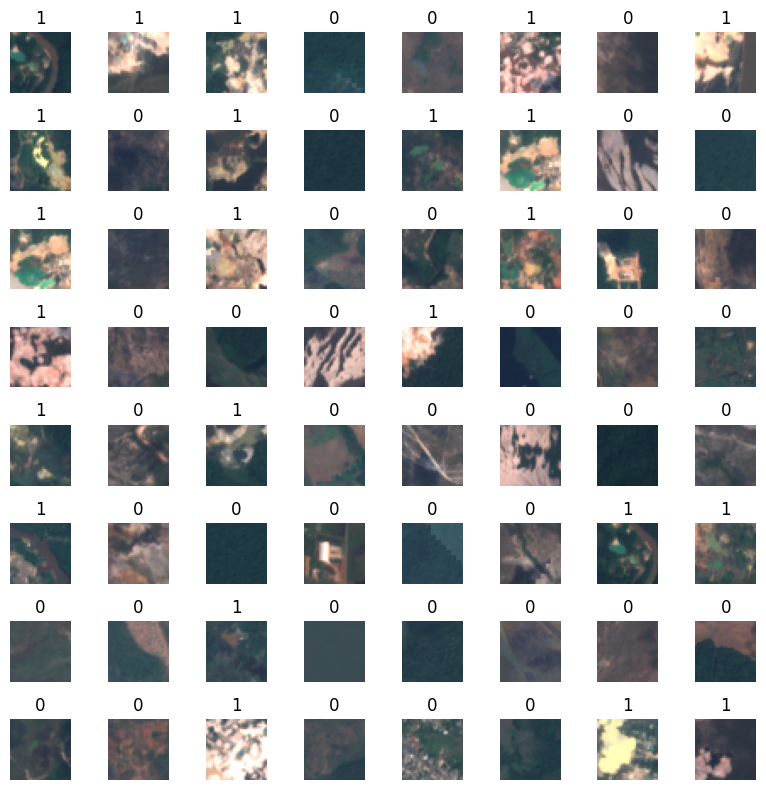

In [68]:
num_samples = 64
indices = np.random.randint(0, len(images), num_samples)
viz_tools.plot_image_grid(images[indices], labels=[int(label) for label in labels[indices]])

## Prepare Data for Training

In [69]:
#for RGBIR, x = normalize(np.copy(images[:,:,:,[1,2,3,8]]))
x = np.clip(dl_utils.normalize(np.copy(images)), 0, 1)
y = labels
x, y = shuffle(x, y, random_state=22)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Num Train:		 1577
Num Test:		 176
Percent Negative Train:	 64.1
Percent Negative Test:	 67.6


## Create Model

In [71]:
input_shape = x_train.shape[1:]
print("Input Shape:", input_shape)

Input Shape: (36, 36, 12)


/Users/ckruse/.pyenv/versions/3.7.9/envs/venv-plastics/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1577, 36, 36, 12) (12 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


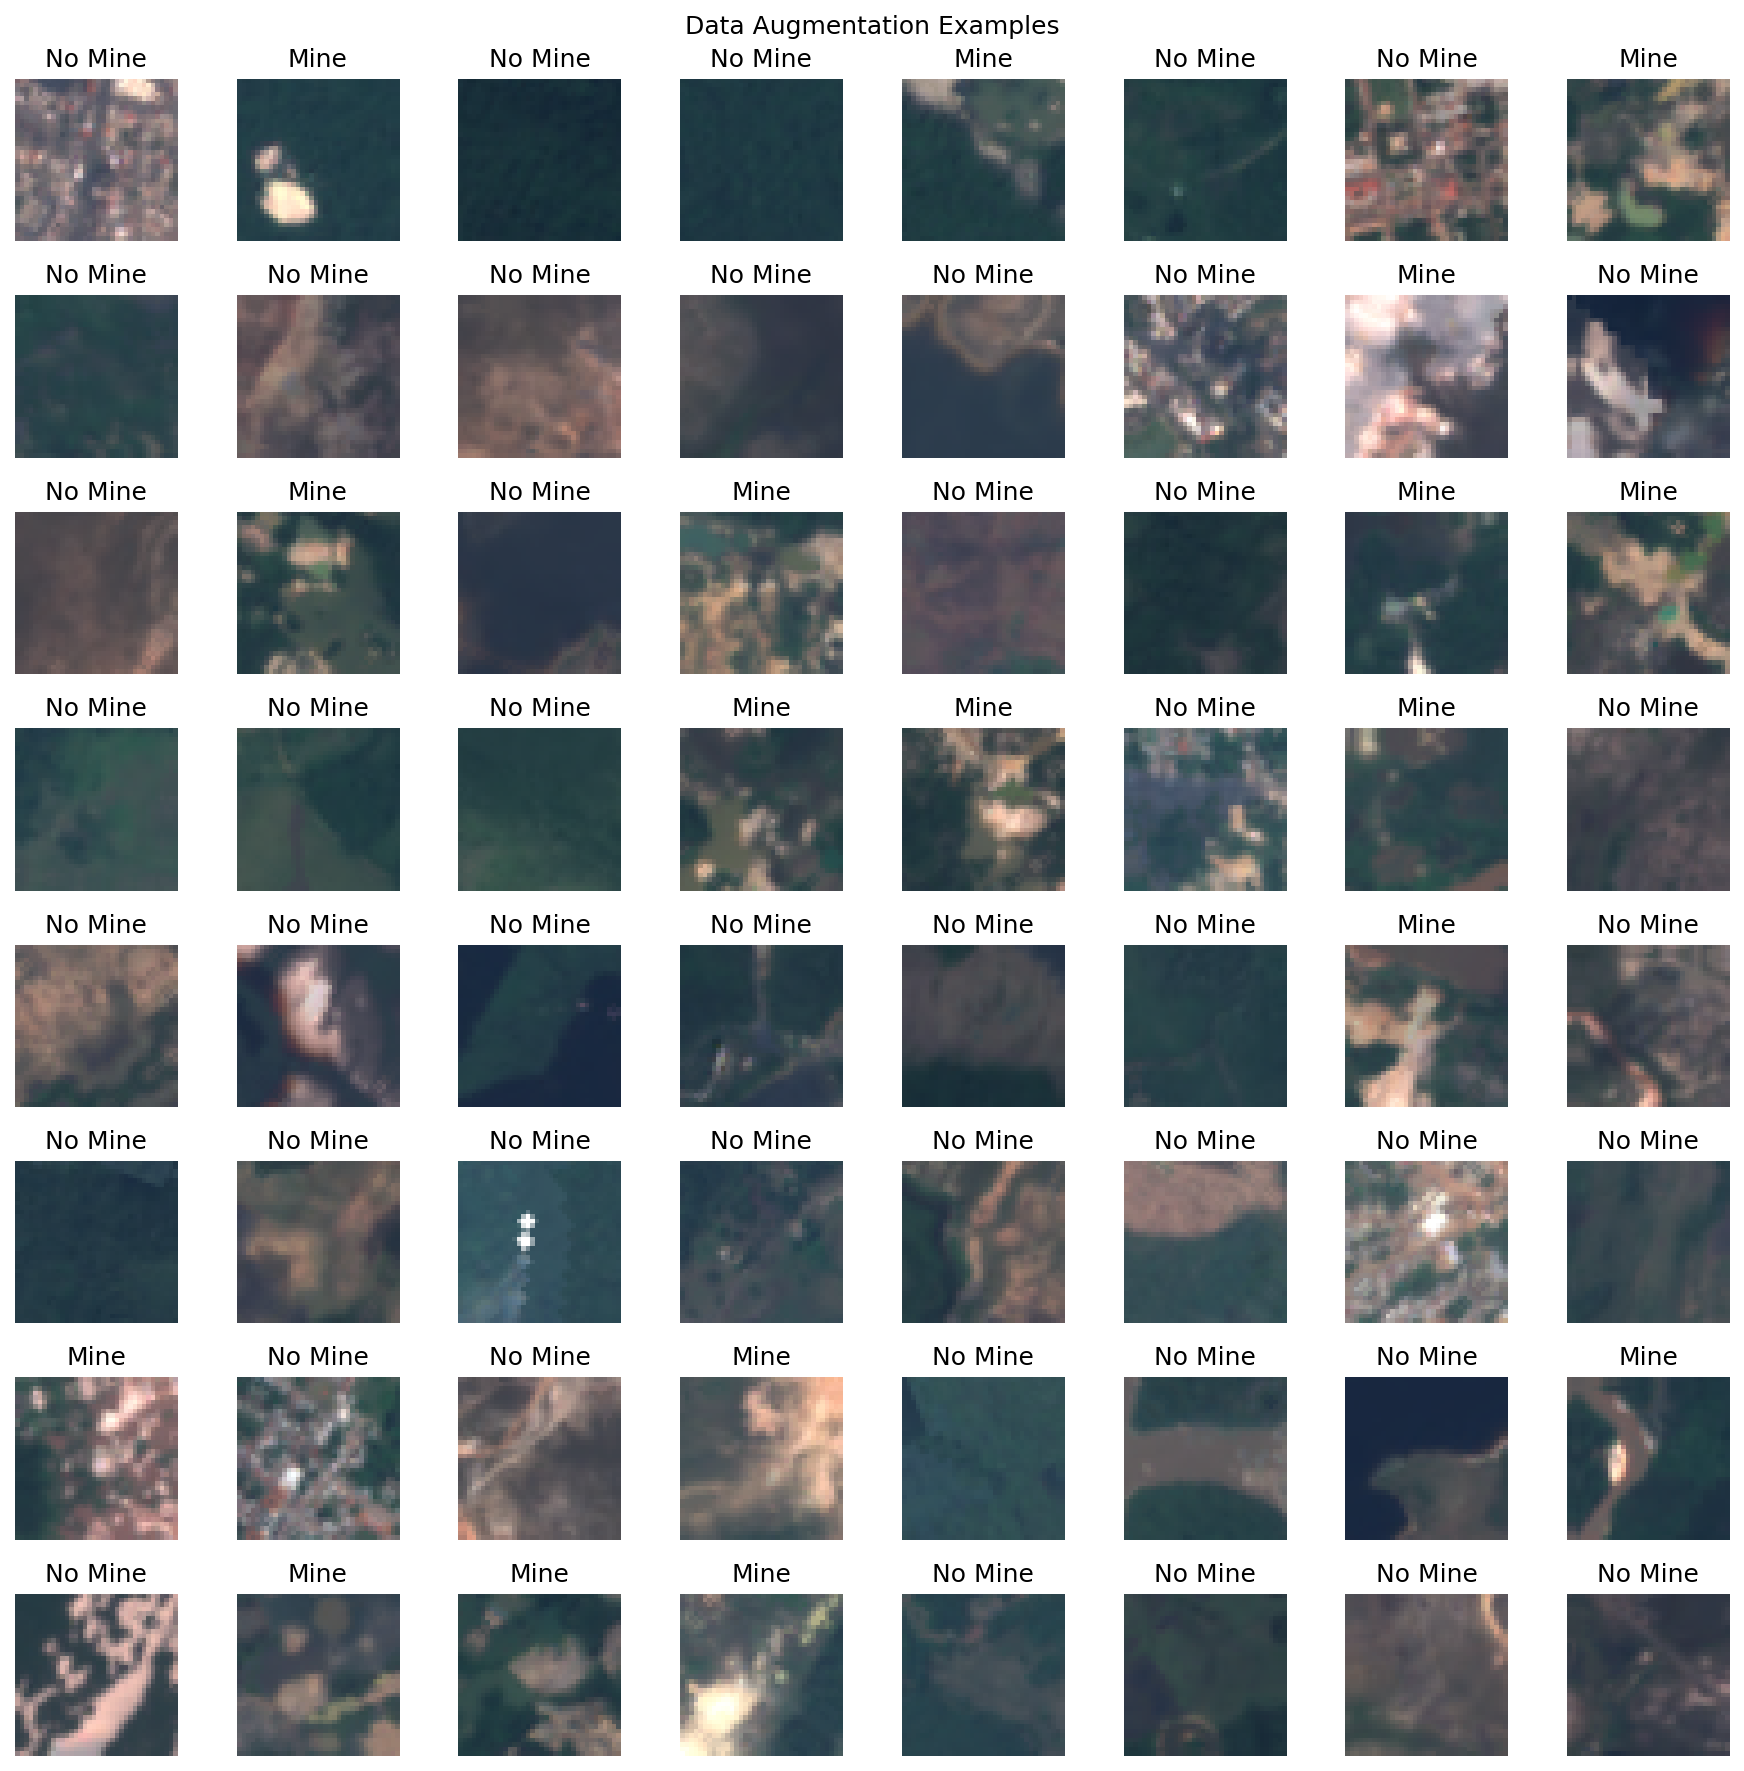

In [72]:
augmentation_parameters = {
    'featurewise_center': False,
    'rotation_range': 360,
    #'width_shift_range': [0.9, 1.1],
    #'height_shift_range': [0.9, 1.1],
    #'shear_range': 10,
    #'zoom_range': [0.8, 1.2],
    'vertical_flip': True,
    'horizontal_flip': True,
    # Fill options: "constant", "nearest", "reflect" or "wrap"
    'fill_mode': 'reflect'
}

datagen = ImageDataGenerator(**augmentation_parameters)


plt.figure(figsize=(12,12), facecolor=(1,1,1), dpi=150)
img, labels = datagen.flow(x_train, y_train, batch_size=64).next()
for index, (image, label) in enumerate(zip(img, labels)):
    rgb = image[:,:,3:0:-1]
    plt.subplot(8, 8, index+1)
    plt.imshow(np.clip(rgb, 0, 1))
    if label[1] == 1:
        plt.title('Mine')
    else:
        plt.title('No Mine')
    plt.axis('off')
plt.suptitle('Data Augmentation Examples')
plt.tight_layout()
plt.show()
    

In [73]:
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3), padding='same', activation="relu"),
        layers.Conv2D(32, kernel_size=(3), padding='same', activation="relu"),
        layers.MaxPooling2D(pool_size=(2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        #layers.Dense(32, activation="relu"),
        #layers.Dropout(0.1),
        #layers.Dense(32, activation="relu"),
        layers.Dense(num_classes, activation="softmax")])
model.summary()

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

train_accuracy = []
test_accuracy = []

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 36, 36, 16)        1744      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 36, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10368)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                663616    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

## Train Model

In [74]:
batch_size = 16
epochs = 32
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
          epochs=epochs, 
          validation_data = (x_test, y_test),
          verbose = 1
         )
train_accuracy += model.history.history['accuracy']
test_accuracy += model.history.history['val_accuracy']

Epoch 1/32
99/99 [==============================] - 5s 42ms/step - loss: 0.5771 - accuracy: 0.7121 - val_loss: 0.6062 - val_accuracy: 0.6193
Epoch 2/32
99/99 [==============================] - 4s 37ms/step - loss: 0.3696 - accuracy: 0.8435 - val_loss: 0.3351 - val_accuracy: 0.8523
Epoch 3/32
99/99 [==============================] - 4s 36ms/step - loss: 0.3036 - accuracy: 0.8776 - val_loss: 0.2663 - val_accuracy: 0.8977
Epoch 4/32
99/99 [==============================] - 4s 38ms/step - loss: 0.2802 - accuracy: 0.8990 - val_loss: 0.1907 - val_accuracy: 0.9375
Epoch 5/32
99/99 [==============================] - 4s 39ms/step - loss: 0.2667 - accuracy: 0.9053 - val_loss: 0.2763 - val_accuracy: 0.9148
Epoch 6/32
99/99 [==============================] - 4s 40ms/step - loss: 0.2633 - accuracy: 0.8968 - val_loss: 0.1752 - val_accuracy: 0.9318
Epoch 7/32
99/99 [==============================] - 4s 43ms/step - loss: 0.2154 - accuracy: 0.9235 - val_loss: 0.2513 - val_accuracy: 0.8920
Epoch 8/32
99

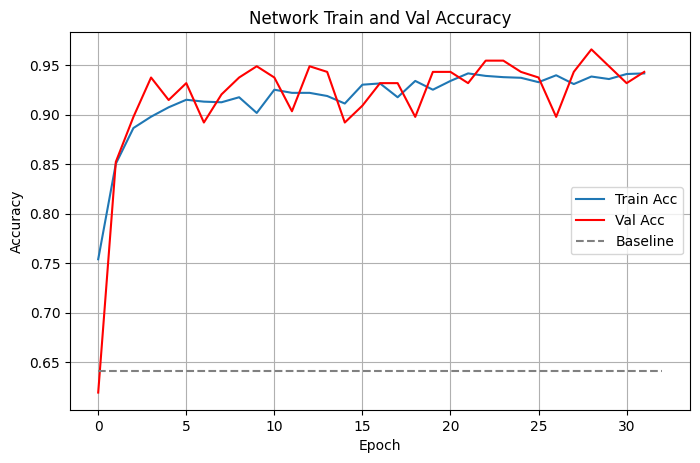

In [75]:
plt.figure(figsize=(8,5), dpi=100, facecolor=(1,1,1))
plt.plot(train_accuracy, label='Train Acc')
plt.plot(test_accuracy, c='r', label='Val Acc')
percent_negative = (sum(y_train == 0.0) / len(y_train))[1]
plt.plot([0, len(train_accuracy)], [percent_negative, percent_negative], '--', c='gray', label='Baseline')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Network Train and Val Accuracy')
plt.show()

In [76]:
threshold = 0.8
print("Test Set Metrics:")
print(classification_report(y_test[:,1], model.predict(x_test)[:,1] > threshold, 
                            target_names=['No Mine', 'Mine']))

Test Set Metrics:
              precision    recall  f1-score   support

     No Mine       0.98      0.94      0.96       119
        Mine       0.89      0.96      0.92        57

    accuracy                           0.95       176
   macro avg       0.93      0.95      0.94       176
weighted avg       0.95      0.95      0.95       176



In [ ]:
version_number = '1.2'
current_date = date.today()
model_name = f"{resolution}px_v{version_number}_{current_date.isoformat()}"

#assert not os.path.exists('../models/' + model_name + '.h5'), f"Model of name {model_name} already exists"

with open('../models/' + model_name + '_config.txt', 'w') as f:
    f.write('Input Data:\n')
    [f.write('\t' + file + '\n') for file in input_data_files]
    f.write('\n\nAugmentation Parameters:\n')
    for k, v in zip(augmentation_parameters.keys(), augmentation_parameters.values()):
        f.write(f"\t{k}: {v}\n")
    f.write(f"\nBatch Size: {batch_size}")
    f.write(f"\nTraining Epochs: {len(train_accuracy)}")
    f.write(f'\n\nClassification Report at {threshold}\n')
    f.write(classification_report(y_test[:,1], model.predict(x_test)[:,1] > threshold, 
                            target_names=['No Mine', 'Mine']))
        

model.save(f'../models/{model_name}.h5')

## Evaluate Model Performance

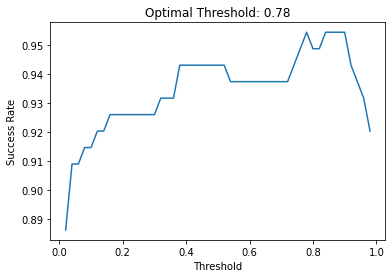

In [77]:
test_model = model

images = x_test
labels = y_test

thresh = []
score = []
for threshold in range(2, 100, 2):
    threshold /= 100
    thresh.append(threshold)
    test_labels = [np.argmax(y) for y in labels]
    test_preds = [pred > threshold for pred in test_model.predict(images)[:,1]]
    score.append(1 - np.sum(np.array(test_labels) != np.array(test_preds)) / len(test_labels))
    #print(np.sum(np.array(test_labels) != np.array(test_preds)), "of", len(test_labels), "test set predictions incorrect")
plt.plot(thresh, score)
plt.ylabel('Success Rate')
plt.xlabel('Threshold')
plt.title(f"Optimal Threshold: {thresh[np.argmax(score)]:.2f}")
plt.show()
optimal_threshold = thresh[np.argmax(score)]

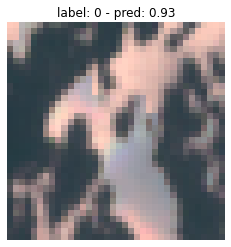

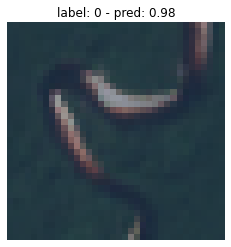

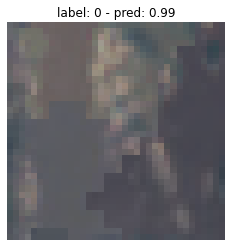

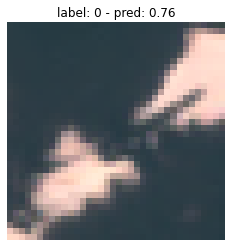

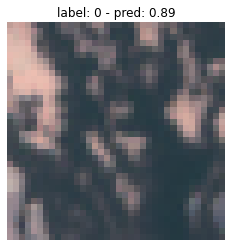

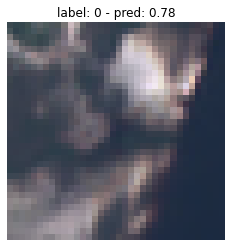

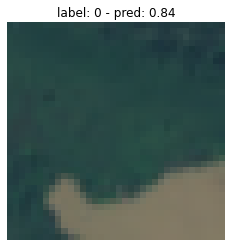

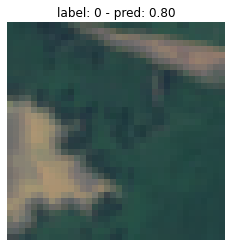

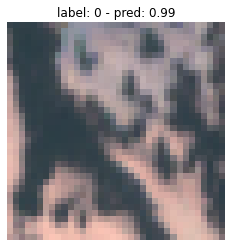

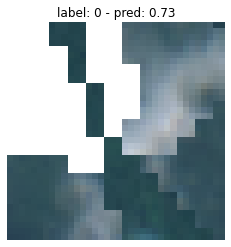

In [78]:
threshold = 0.5

test_labels = [np.argmax(y) for y in labels]
test_preds = [pred > threshold for pred in test_model.predict(images)[:,1]]
for index, (label, pred, img) in enumerate(zip(test_labels, test_model.predict(images)[:,1], images)):
    if pred < threshold:
        binary_pred = 0
    else:
        binary_pred = 1
    if label != binary_pred:
        rgb = img[:,:,3:0:-1]
        plt.imshow(np.clip(rgb, 0, 1))
        plt.title(f"label: {label} - pred: {pred:.2f}")
        plt.axis('off')
        plt.show()

## Test on dataset

In [ ]:
resolution = 28

input_data_files = ['corrupted'
                   ]

images = np.zeros((0, resolution, resolution, 12))
labels = []
for fname in input_data_files:
    images_fname = str(resolution) + '_px_' + fname + '_images.pkl'
    labels_fname = str(resolution) + '_px_' + fname + '_labels.pkl'
    with open('../data/caroni_train/' + images_fname, 'rb') as f:
        images = np.concatenate((images, pickle.load(f)))
    with open('../data/caroni_train/' + labels_fname, 'rb') as f:
        labels = np.concatenate((labels, pickle.load(f)))

print(len(images), "samples loaded")
print(sum(labels == 1), "positive samples")
print(sum(labels == 0), "negative samples")

In [ ]:
preds = model.predict(normalize(images))[:,1]

In [ ]:
plt.hist(preds[preds > 0.01]);

In [ ]:
num_img = int(np.ceil(np.sqrt(len(images[:225]))))
plt.figure(figsize=(12,12), dpi=250, facecolor=(1,1,1))
for index, (img, pred, label) in enumerate(zip(images[:225], preds[:225], labels[:225])):
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    plt.subplot(num_img, num_img, index + 1)
    plt.imshow(np.clip(normalize(rgb), 0, 1))
    plt.title(f"Label: {label:.0f}\nPred: {pred:.1f}", size=6)
    plt.axis('off')
plt.tight_layout()
name = 'V5 Predictions on Corrupted Sample'
plt.suptitle(name, y=1.02, size=16)
plt.savefig('../figures/' + name + '.png', bbox_inches='tight')
plt.show()